In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from pmdarima import auto_arima

In [5]:
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

2024-09-15 18:26:09.009 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [6]:
# Load the data
cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

In [7]:
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

In [8]:
# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

In [9]:
#Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [10]:
# Display the DataFrame to verify
print(cbs.head())

            id      sbi    period  sick_leave_percentage      period_title  \
date                                                                         
1996-01-01   0  T001081  1996KW01                    5.5  1996 1e kwartaal   
1996-04-01   1  T001081  1996KW02                    4.6  1996 2e kwartaal   
1996-07-01   2  T001081  1996KW03                    4.0  1996 3e kwartaal   
1996-10-01   3  T001081  1996KW04                    4.7  1996 4e kwartaal   
1997-01-01   5  T001081  1997KW01                    4.9  1997 1e kwartaal   

           period_status  period_year period_type  period_quarter_number  \
date                                                                       
1996-01-01    Definitief         1996          KW                      1   
1996-04-01    Definitief         1996          KW                      2   
1996-07-01    Definitief         1996          KW                      3   
1996-10-01    Definitief         1996          KW                      4 

In [11]:
# Define a function to filter and resample data for a specific 'sbi_title'
def process_sbi_data(sbi_code):
    # Filter the data for the specific 'sbi_title'
    filtered_data = cbs[cbs['sbi'] == sbi_code]
    
    # Resample to ensure quarterly frequency
    filtered_data = filtered_data.resample('QS').asfreq()
    
    # Display the resampled data to verify
    print(filtered_data.head())
    
    return filtered_data

In [12]:
# Example: Process data for "A-U Alle economische activiteiten" (code: T001081)
sbi_code = 'T001081'
sbi_data = process_sbi_data(sbi_code)

            id      sbi    period  sick_leave_percentage      period_title  \
date                                                                         
1996-01-01   0  T001081  1996KW01                    5.5  1996 1e kwartaal   
1996-04-01   1  T001081  1996KW02                    4.6  1996 2e kwartaal   
1996-07-01   2  T001081  1996KW03                    4.0  1996 3e kwartaal   
1996-10-01   3  T001081  1996KW04                    4.7  1996 4e kwartaal   
1997-01-01   5  T001081  1997KW01                    4.9  1997 1e kwartaal   

           period_status  period_year period_type  period_quarter_number  \
date                                                                       
1996-01-01    Definitief         1996          KW                      1   
1996-04-01    Definitief         1996          KW                      2   
1996-07-01    Definitief         1996          KW                      3   
1996-10-01    Definitief         1996          KW                      4 

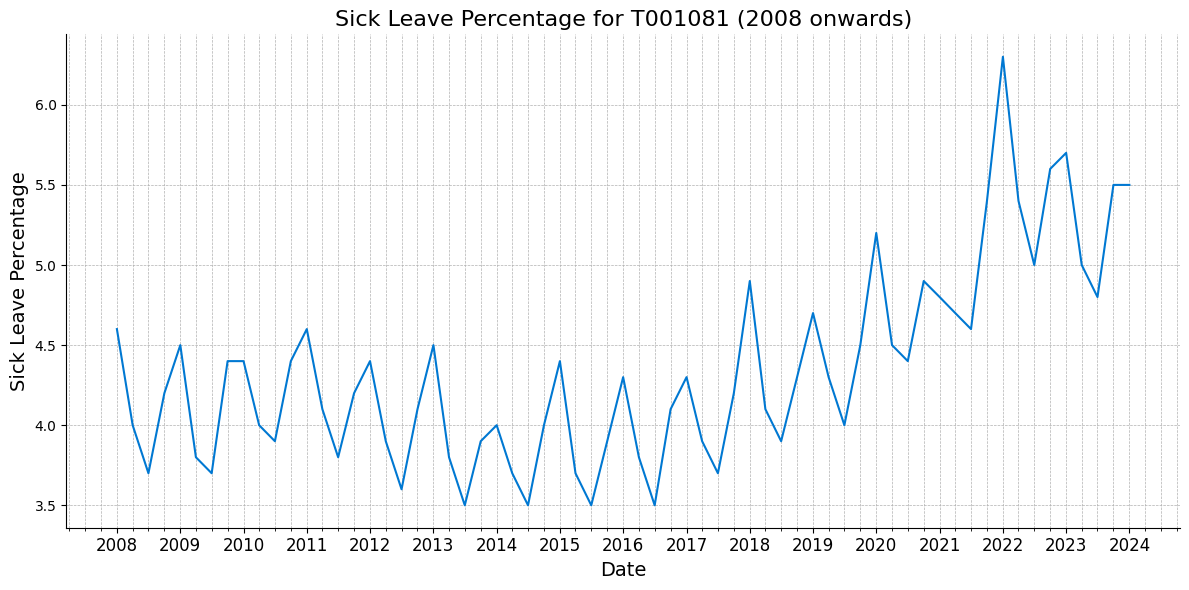

In [13]:
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten

# Filter data based on 'sbi_title'
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

# Further filter the data to include only records from 2008 onwards
filtered_cbs = filtered_cbs[filtered_cbs.index >= '2008-01-01']

# Plot the sick_leave_percentage as a line plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_cbs.index, filtered_cbs['sick_leave_percentage'], linestyle='-', color='#0078d2')

# Add titles and labels
plt.title(f'Sick Leave Percentage for {sbi_code} (2008 onwards)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sick Leave Percentage', fontsize=14)

# Customize x-axis to show quarters with vertical gridlines and display year at the start of Q1
ax = plt.gca()

# Set major ticks for the start of each year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set minor ticks for each quarter (January, April, July, October)
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=0)  # Hide labels for minor ticks (quarters)

# Draw grid lines for both major (years) and minor (quarters) ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the plot to remove axis lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# Show the plot
plt.tight_layout()
plt.show()

In [14]:
# Example: Perform seasonal decomposition
result = seasonal_decompose(sbi_data['sick_leave_percentage'], model='additive', period=4)

In [15]:
# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid
observed = result.observed

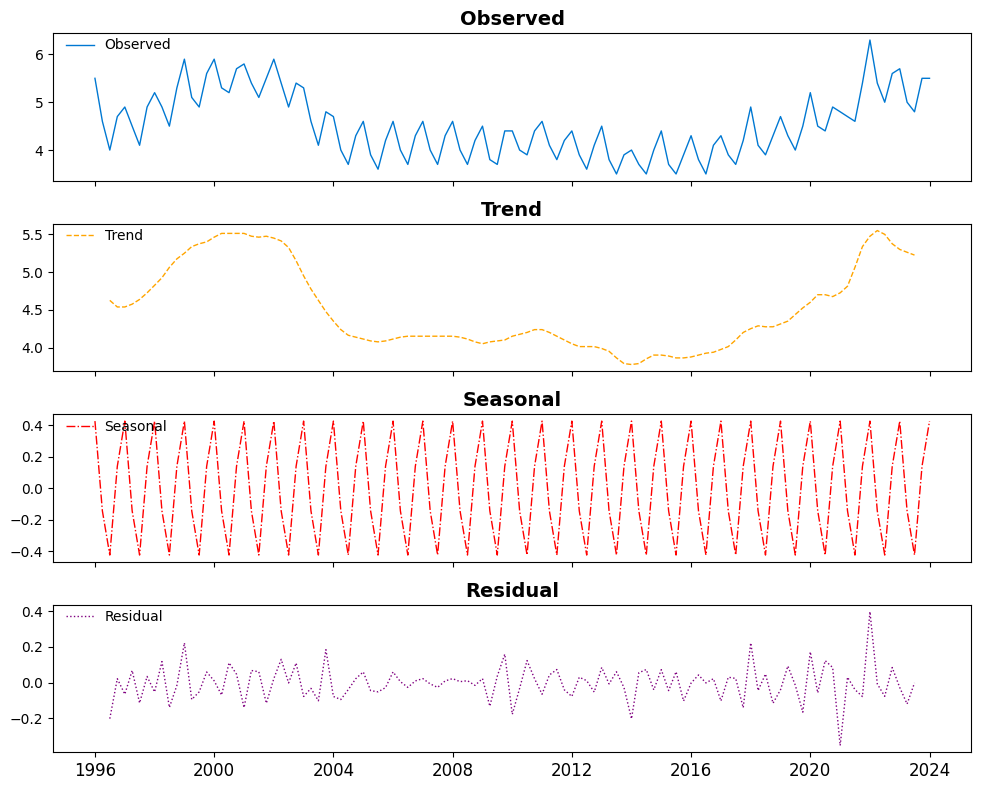

In [16]:
# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axes[0].plot(observed, label='Observed', color='#0078D2', linestyle='-', linewidth=1)
axes[0].set_title('Observed', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.05), fontsize=10, frameon=False)

axes[1].plot(trend, label='Trend', color='orange', linestyle='--', linewidth=1)
axes[1].set_title('Trend', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', bbox_to_anchor=(0, 1.05), fontsize=10, frameon=False)

axes[2].plot(seasonal, label='Seasonal', color='red', linestyle='-.', linewidth=1)
axes[2].set_title('Seasonal', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', bbox_to_anchor=(0, 1.05), fontsize=10, frameon=False)

axes[3].plot(residual, label='Residual', color='purple', linestyle=':', linewidth=1)
axes[3].set_title('Residual', fontsize=14, fontweight='bold')
axes[3].legend(loc='upper left', bbox_to_anchor=(0, 1.05), fontsize=10, frameon=False)

for ax in axes:
    ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

In [17]:
from pmdarima import auto_arima

# Filter the data to include only records from 2008 onwards
filtered_cbs = cbs[cbs.index >= '2008-01-01']

# Verify that there are no NaN values in the 'sick_leave_percentage' column
if filtered_cbs['sick_leave_percentage'].isnull().sum() > 0:
    print("Warning: There are still NaN values in the filtered data.")
else:
    print("No NaN values found in the filtered data from 2008 onwards.")

# Run auto_arima on the filtered data
model = auto_arima(filtered_cbs['sick_leave_percentage'], seasonal=True, m=4)

# Print the summary of the ARIMA model
print(model.summary())


No NaN values found in the filtered data from 2008 onwards.
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 2535
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2], 4)   Log Likelihood               -1096.390
Date:                                Sun, 15 Sep 2024   AIC                           2210.781
Time:                                        18:28:37   BIC                           2263.319
Sample:                                             0   HQIC                          2229.841
                                               - 2535                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9165 

In [18]:
# Filter data based on 'sbi_title' first (assuming this step was done earlier)
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

# Further filter the data to include only records from 2008 onwards
filtered_cbs = filtered_cbs[filtered_cbs.index >= '2008-01-01']

# Get the length of the filtered DataFrame
number_of_records = len(filtered_cbs)

# Print the number of records
print(f"Number of records for {sbi_code} from 2008 onwards: {number_of_records}")


Number of records for T001081 from 2008 onwards: 65


In [19]:
# Split the data into training and testing sets
train = filtered_cbs[:'2021-12-31']  # Up to the last quarter of 2021
test = filtered_cbs['2022-01-01':'2022-12-31']  # Only the 4 quarters of 2022

In [20]:
# Verify the lengths of the train and test sets
print(f"Training set length: {len(train)}")
print(f"Testing set length: {len(test)}")

Training set length: 56
Testing set length: 4


In [21]:
# Output the first few records to verify correctness
print("\nTraining Set:")
print(train.head())
print("\nTesting Set:")
print(test.head())


Training Set:
            id      sbi    period  sick_leave_percentage      period_title  \
date                                                                         
2008-01-01  60  T001081  2008KW01                    4.6  2008 1e kwartaal   
2008-04-01  61  T001081  2008KW02                    4.0  2008 2e kwartaal   
2008-07-01  62  T001081  2008KW03                    3.7  2008 3e kwartaal   
2008-10-01  63  T001081  2008KW04                    4.2  2008 4e kwartaal   
2009-01-01  65  T001081  2009KW01                    4.5  2009 1e kwartaal   

           period_status  period_year period_type  period_quarter_number  \
date                                                                       
2008-01-01    Definitief         2008          KW                      1   
2008-04-01    Definitief         2008          KW                      2   
2008-07-01    Definitief         2008          KW                      3   
2008-10-01    Definitief         2008          KW         